In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import os
from rdb_functions import generate_b1_b0
from rdb_functions import fill_nas


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading data

In [3]:
data=pd.read_csv(os.path.join('data','BJ_to_model.csv'))

### Splitting info by year

We don't have prices data in 2010 so we are going to estimate it. In order to do that we have to split the data from 2010 and 2020.

In [4]:
data_20=data[data['tiempo']==2020].reset_index(drop=True)
data_10=data[data['tiempo']==2010].reset_index(drop=True)

print(data_20.shape)
print(data_10.shape)

(154, 32)
(154, 32)


### Plotting $price/m^2$ vs variables

29


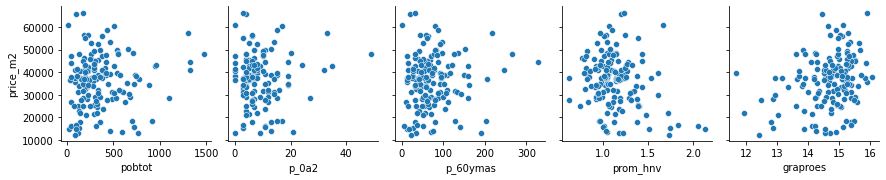

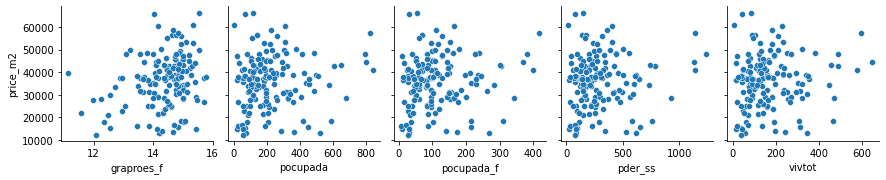

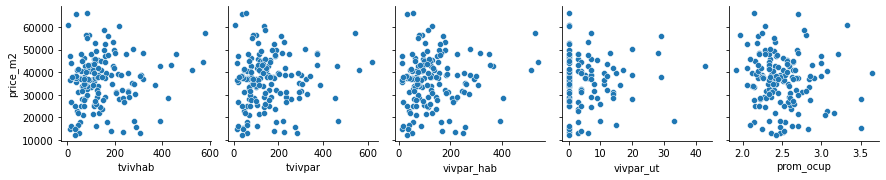

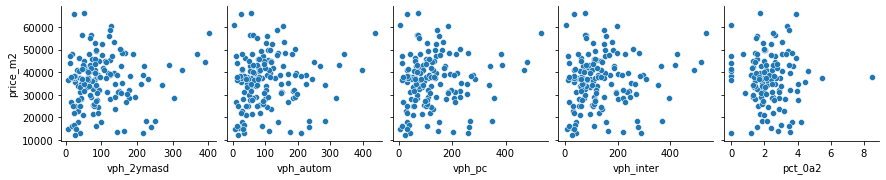

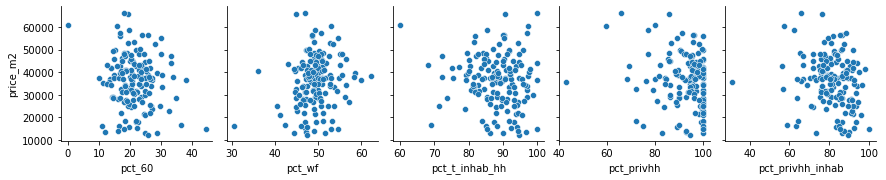

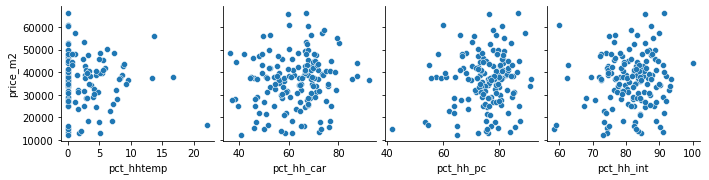

In [5]:
variables_plot=list(data_20.drop(columns=['id','price_m2','tiempo']))

total=len(variables_plot)
print(total)
i=0
while i<total:
    
    try:
        pp = sns.pairplot(data=data_20,
                      y_vars=['price_m2'],
                      x_vars=variables_plot[i:i+5],diag_kind = None)
        i=i+5
    except:
        pp = sns.pairplot(data=data_20,
                      y_vars=['price_m2'],
                      x_vars=variables_plot[i:],diag_kind = None)
    
    

### Filtering data to make the model

In [6]:
X=data_20.drop(columns=['price_m2','id','tiempo'])
y=data_20.price_m2

In [7]:
nas=X.isna().sum()

In [8]:
nas

pobtot               0
p_0a2               21
p_60ymas             0
prom_hnv             0
graproes             0
graproes_f           0
pocupada             0
pocupada_f           1
pder_ss              0
vivtot               0
tvivhab              0
tvivpar              0
vivpar_hab           1
vivpar_ut           44
prom_ocup            0
vph_2ymasd           1
vph_autom            0
vph_pc               0
vph_inter            0
pct_0a2             21
pct_60               0
pct_wf               1
pct_t_inhab_hh       0
pct_privhh           0
pct_privhh_inhab     1
pct_hhtemp          44
pct_hh_car           0
pct_hh_pc            0
pct_hh_int           0
dtype: int64

There are several NAs in our data in the next step we filled the data using a linear regression with total population as predictor.

## Filling NAs with linear regression

To predict $price/m^2$ we need features related with this variable. Using economical sense and doing a visual analysis we determined the percentage of households with at least one PC, one car, the percentage of women working and the average of years spent in education by the population were the variables more related.

In [9]:
variables_kept=['pct_hh_pc','pct_wf','pobtot','pct_hh_car','graproes']

X_filled=X[variables_kept].copy()

for column in list(X_filled):
    b1_b0=generate_b1_b0(X,'pobtot',column)
    X_filled[column]=fill_nas(X_filled[column],X_filled['pobtot'],b1_b0)

In [10]:
print(X_filled.isna().sum())
print(X_filled.shape)

pct_hh_pc     0
pct_wf        0
pobtot        0
pct_hh_car    0
graproes      0
dtype: int64
(154, 5)


In [11]:
X_filled.drop(columns=['pobtot'],inplace=True)

## Splitting in train and test

In this section we split the data in test data and train data. We did this because in further analysys the idea is to tune the hyperparameters to have better estimators.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.33, random_state=42)

In [13]:
corlist=['price_m2']
corlist.extend(variables_kept)

### Showing correlation between variables in a heatmap

<AxesSubplot:>

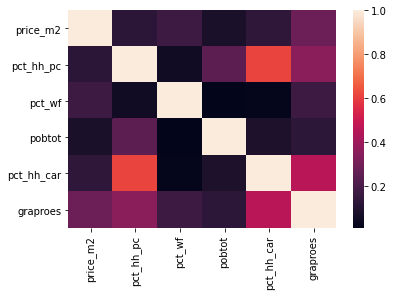

In [14]:
sns.heatmap((data_20[corlist]).corr())

### Gradient Boosting Regressor

In the next step we estimate the price in 2010, we used a Gradient Boosting Regressor just to get familiar with the model, there was no particular reason to use this model besides their good properties, the parameters were by default. In further analysis these parameters are going to be optimized.

In [15]:
gbr = GradientBoostingRegressor(
learning_rate=0.1,
n_estimators=200,
subsample=0.6,
random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42, subsample=0.6)

The follow code shows the prediction weight of each variable.

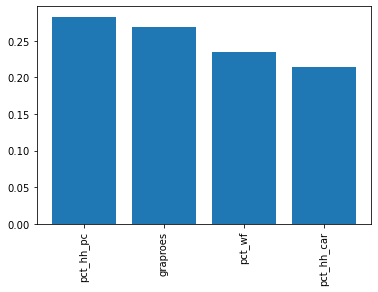

In [16]:
# feature importances from random forest model
importances = gbr.feature_importances_
# index of greatest to least feature importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))
# create tick labels
feature_names=list(X_filled)
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In this part we predict the prices in 2010. 

In [17]:
X_10=data_10.drop(columns=['price_m2','id','tiempo'])

X_filled_10=X_10[variables_kept].copy()

for column in list(X_filled_10):
    b1_b0=generate_b1_b0(X_filled_10,'pobtot',column)
    X_filled_10[column]=fill_nas(X_filled_10[column],X_filled_10['pobtot'],b1_b0)

X_filled_10.drop(columns=['pobtot'],inplace=True)
    
gbr.predict(X_filled_10)
    
growth=100*(y/gbr.predict(X_filled_10))-100
    
predictions=pd.DataFrame({'precio m2 2010 predicted':gbr.predict(X_filled_10),
               'precio m2 2020':y,
               'growth':growth})

In [18]:
data_10['growth']=growth
results=data_10[['id','growth']]

In [19]:
predictions.describe()

,precio m2 2010 predicted,precio m2 2020,growth
count,154.000000,154.000000,154.000000
mean,32447.378555,36297.835132,20.564723
std,8534.392421,11477.179341,56.545571
min,11801.755412,12222.222222,-64.689326
25%,25756.974746,28556.212434,-14.973478
50%,33241.913781,37414.232809,8.907796
75%,38472.860428,43125.739166,39.159309
max,49969.902074,66483.516484,261.096563


We decided to show only movements that we didn't consider outliers. 

# Percentage increase distribution in $price/m^2$ in Benito Juarez

95
154


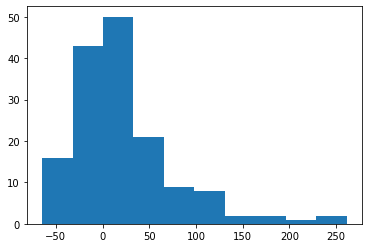

In [20]:
plt.hist(results['growth'])
print((results['growth']>0).sum())
print(len(results['growth']))

### Exporting the results of the model to visualize the results.

In [21]:
results.to_csv(os.path.join('data','results.csv'),index=False)

In the next plots we analyzed how the percentages changed in percentual points.

Percentual points change in pct_hh_pc


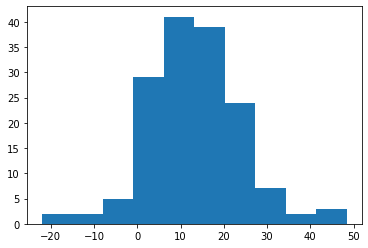

Percentual points change in pct_wf


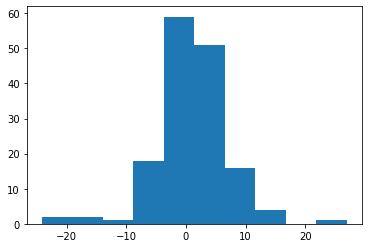

Percentual points change in pct_hh_car


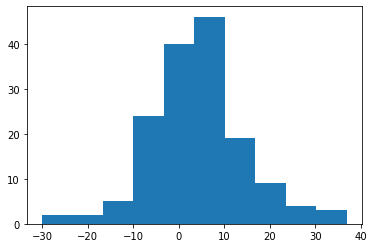

Percentual points change in graproes


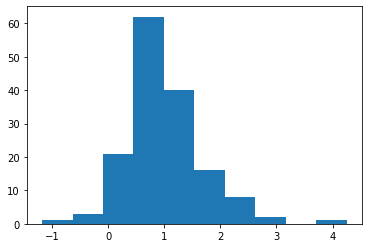

In [22]:
for column in list(X_filled):
    change=X_filled[column]-X_filled_10[column]

    print(f'Percentual points change in {column}')
    plt.hist(change)
    plt.show()
    